# Burgers' Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

import time

from scipy import io
from matplotlib import cm

from RF import *

In [2]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid

In [4]:
# read training data and test data
x_train, y_train, x_test, y_test, grid = get_data(2048-200, 200)
# show shapes of training and test samples
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1848, 128), (1848, 128), (200, 128), (200, 128))

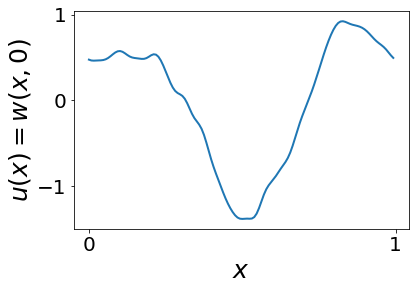

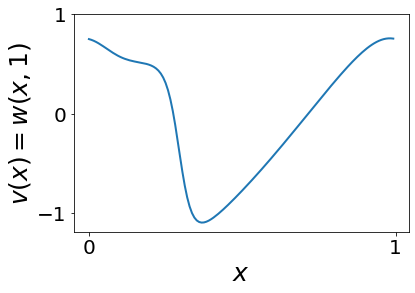

In [5]:
# Visualize one training inputs
idx = 1

# one example of training input
plt.figure(1)
plt.plot(grid, x_train[idx], linewidth=2)
plt.xlabel(r'$x$', size=25)
plt.ylabel(r'$u(x) = w(x,0)$', size=25)
plt.xticks([0,1], fontsize=20)
plt.yticks([-1,0,1], fontsize=20)
plt.savefig('Burger_input.pdf', bbox_inches = 'tight')

# one example of training output
plt.figure(2)
plt.plot(grid, y_train[idx], linewidth=2)
plt.xlabel(r'$x$', size=25)
plt.ylabel(r'$v(x) = w(x,1)$', size=25)
plt.xticks([0,1], fontsize=20)
plt.yticks([-1,0,1], fontsize=20)
plt.savefig('Burger_output.pdf', bbox_inches = 'tight')

## Random feature method

In [6]:
######################### Cauchy random feature
# number of features
N = 100000
# scaling parameter gamma
gamma = 0.01
# generate random feature matrix
x_train_RF, x_test_RF = RF_Cauchy(gamma, N, x_train, x_test)
# train a linear regression model
model = Ridge(alpha=1e-12)
start = time.time()
model.fit(x_train_RF, y_train)
pred = model.predict(x_test_RF)
end = time.time()
# report relative prediction error and clock time
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
print(f'Test error of Cauchy random feature model is {e:.2e}.\n')
print(f'Clock time is {end-start:.2f} seconds')

Test error of Cauchy random feature model is 0.03823823113837829.

Clock time is 3.0667762756347656 seconds


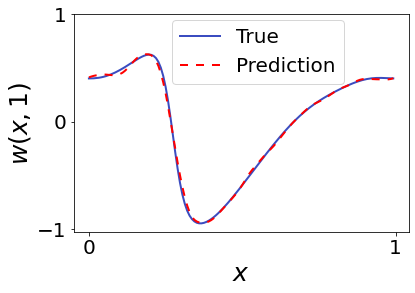

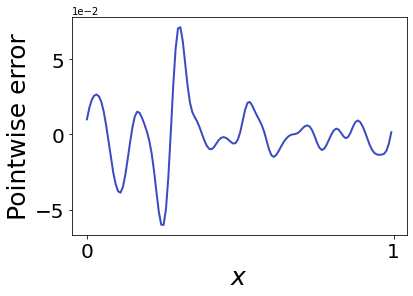

In [7]:
# visualize the result
idx = 20

# Figure 1: test + prediction
plt.figure(1)
plt.plot(grid, y_test[idx],  label = "True",  linewidth=2.0, color= cm.coolwarm(0.0))
plt.plot(grid, pred[idx],  label = "Prediction", linestyle='--',dashes=(4, 4), color = 'red',  linewidth=2.0)
plt.xlabel(r'$x$', size= 25)
plt.ylabel(r'$w(x,1)$', size= 25)
plt.legend(loc="upper center", bbox_to_anchor=(0.55,1.02),fontsize=20)
plt.xticks([0,1], fontsize=20)
plt.yticks([-1,0,1], fontsize=20)
plt.savefig('Burger_test_pred.pdf', bbox_inches = 'tight')

# Figure 2: pointwise error (Prediction - test)
plt.figure(2)
plt.plot(grid, pred[idx]-y_test[idx],linewidth=2.0, color= cm.coolwarm(0.0))
plt.xlabel(r'$x$', size= 25)
plt.ylabel('Pointwise error', size= 25)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xticks([0,1], fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.savefig('Burger_error.pdf', bbox_inches = 'tight')

In [8]:
######################## Gaussian random feature
# number of features
N = 100000
# scaling parameter gamma
gamma = 0.02
# generate random feature matrix
x_train_RF, x_test_RF = RF_Gaussian(gamma, N, x_train, x_test)
# train a linear regression model
model = Ridge(alpha=1e-7)
start = time.time()
model.fit(x_train_RF, y_train)
pred = model.predict(x_test_RF)
end = time.time()
# report relative prediction error and clock time
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
print(f'Test error of Gaussian random feature model is {e:.2e}.\n')
print(f'Clock time is {end-start:.2f} seconds')

Test error of Gaussian random feature model is 0.026984036752004992.

Clock time is 3.08 seconds


## Kernel method

In [9]:
bandwidth = 1
kernel = RBF(length_scale = bandwidth)
model = GaussianProcessRegressor(kernel, alpha = 1e-10)

start = time.time()
model.fit(x_train, y_train)
pred = model.predict(x_test)
end = time.time()
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Gaussian kernel Prediction error is {e:.2e} \n')
print(f'Computation time is {end-start:.2f}')

Gaussian kernel Prediction error is 0.03756531468461097 

Computation time is 107.91195392608643


In [10]:
kernel = Matern(nu = 1.5, length_scale = 1.0)
model = GaussianProcessRegressor(kernel, alpha = 1e-10, normalize_y = False)

start = time.time()
model.fit(x_train, y_train)
pred = model.predict(x_test)
end = time.time()
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Gaussian kernel Prediction error is {e:.2e} \n')
print(f'Computation time is {end-start:.2f}')

Gaussian kernel Prediction error is 0.020314012562312148 

Computation time is 68.02979111671448
